# Part 4: Apply hypothesis testing to explore what makes a movie successful.

# Assignment - Questions to Answer

## Q - 1: Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

- Perform a statistical test to get a mathematically-supported answer.
- Report if you found a significant difference between ratings.
    - If so, what was the p-value of your analysis?
    - And which rating earns the most revenue?
- Prepare a visualization that supports your finding.

## Q-2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

## Q-3:

# Load Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import glob

# Additional Imports
import os, json, math, time
import tmdbsimple as tmdb
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

# Custom Functions

In [2]:
def write_json(new_data, filename): 
    """Appends a list of records (new_data) to a json file (filename). 
    Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""  
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [3]:
def get_movie_with_rating(movie_id):
    """Copied from Coding Dojo Learning Platform"""
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    # save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation==US
        if c['iso_3166_1' ] =='US':
            ## save a "certification" key in the info dict with the certification
            info['certification'] = c['certification']
    
    return info

# Load Data

In [4]:
basics = pd.read_csv("Data/title_basics.csv")
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama
...,...,...,...,...,...,...,...,...,...
81844,tt9914942,movie,Life Without Sara Amat,La vida sense la Sara Amat,0,2019.0,NaN,74,Drama
81845,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
81846,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
81847,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


# Loading API Keys

In [7]:
import json
with open('/Users/osmay/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
login.keys()

dict_keys(['api-key'])

In [9]:
tmdb.api =  login['api-key']

In [12]:
FOLDER = 'Data/'
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['title_basics.csv', 'title_ratings.csv', 'tmdb_results_combined.csv']

# Retreive Year Range

In [15]:
YEARS_TO_GET = range(2010, 2019)
errors = []

In [16]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'

    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)

    #Saving new year as the current df
    #Filter for basics df for only specific year
    df = basics[basics['startYear']==YEAR].copy()
    # saving movie ids to list
    movie_ids = df['tconst'].copy()
    
    ###Stop gap measure to insure previously retrieved data isn't retrieved again
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)

    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

#############################################################################
    #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                  desc=f'Movies from {YEAR}',
                                  position=1,
                                  leave=True):
        try:
            # Retrieve the data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)

        except Exception as e:
            errors.append([movie_id, e])
#############################################################################        
    
    #save file as .csv.gz  
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", 
                         compression="gzip", index=False)

# print number of errors
print(f"- Total errors: {len(errors)}")

YEARS:   0%|          | 0/9 [00:00<?, ?it/s]

Movies from 2010:   0%|          | 0/3848 [00:00<?, ?it/s]

Movies from 2011:   0%|          | 0/4229 [00:00<?, ?it/s]

Movies from 2012:   0%|          | 0/4522 [00:00<?, ?it/s]

Movies from 2013:   0%|          | 0/4710 [00:00<?, ?it/s]

Movies from 2014:   0%|          | 0/4916 [00:00<?, ?it/s]

Movies from 2015:   0%|          | 0/5055 [00:00<?, ?it/s]

Movies from 2016:   0%|          | 0/5255 [00:00<?, ?it/s]

Movies from 2017:   0%|          | 0/5641 [00:00<?, ?it/s]

Movies from 2018:   0%|          | 0/5779 [00:00<?, ?it/s]

- Total errors: 10557


# Using Glob

In [24]:
q = "Data/final_tmdb_data_*.csv.gz"
chunked_files = glob.glob(q)
# Showing the first 5
files_to_get = chunked_files[2:]
files_to_get

['Data\\final_tmdb_data_10.csv.gz',
 'Data\\final_tmdb_data_100.csv.gz',
 'Data\\final_tmdb_data_1000.csv.gz',
 'Data\\final_tmdb_data_1001.csv.gz',
 'Data\\final_tmdb_data_1002.csv.gz',
 'Data\\final_tmdb_data_1003.csv.gz',
 'Data\\final_tmdb_data_1004.csv.gz',
 'Data\\final_tmdb_data_1005.csv.gz',
 'Data\\final_tmdb_data_1006.csv.gz',
 'Data\\final_tmdb_data_1007.csv.gz',
 'Data\\final_tmdb_data_1008.csv.gz',
 'Data\\final_tmdb_data_1009.csv.gz',
 'Data\\final_tmdb_data_101.csv.gz',
 'Data\\final_tmdb_data_1010.csv.gz',
 'Data\\final_tmdb_data_1011.csv.gz',
 'Data\\final_tmdb_data_1012.csv.gz',
 'Data\\final_tmdb_data_1013.csv.gz',
 'Data\\final_tmdb_data_1014.csv.gz',
 'Data\\final_tmdb_data_1015.csv.gz',
 'Data\\final_tmdb_data_1016.csv.gz',
 'Data\\final_tmdb_data_1017.csv.gz',
 'Data\\final_tmdb_data_1018.csv.gz',
 'Data\\final_tmdb_data_1019.csv.gz',
 'Data\\final_tmdb_data_102.csv.gz',
 'Data\\final_tmdb_data_1020.csv.gz',
 'Data\\final_tmdb_data_1021.csv.gz',
 'Data\\final_tmd

In [25]:
## Loading all files as df and appending to a list
df_list = []
for file in files_to_get:
    temp_df = pd.read_csv(file, index_col=0)
    df_list.append(temp_df)
    
## Concatenating the list of dfs into 1 combined
df_combined = pd.concat(df_list)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_combined.drop(index=0, inplace=True)
df_combined.drop(index='0', inplace=True)
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,Two neighbors become intimate after discoverin...,...,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.111,2257.0,PG
tt0118852,0.0,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,"When Harry Levine, an aging, unsuccessful Gree...",...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.804,51.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9906644,0.0,/htoReVItKtolso5VJqFqJDBaOwm.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,635903.0,ml,മനോഹരം,Manoharan is a poster artist struggling to fin...,...,0.0,122.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Manoharam,0.0,6.100,12.0,NaN
tt9913660,0.0,/z6YpkQiWLnRKl5yQD9dSiPDFWN.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,711261.0,en,No Apology,When a group of women struggle to deal with th...,...,0.0,102.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,No Apology,0.0,8.000,1.0,NaN
tt9913872,0.0,/a0kySBmMZ77AqmNA3pDu45GsbCp.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800030.0,es,De la piel del Diablo,NaN,...,0.0,0.0,[],Released,NaN,De la piel del Diablo,0.0,8.200,3.0,NaN


# Clean up data

In [27]:
df_combined['certification'].value_counts()

R                                  5706
NR                                 3085
PG-13                              3018
PG                                 1316
G                                   407
NC-17                               143
Unrated                               5
UR                                    1
Not Rated                             1
ScreamFest Horror Film Festival       1
PG-13                                 1
10                                    1
Name: certification, dtype: int64

Will change:
- '10' = 'G'
- 'PG-13 ' (has extra space) = 'PG-13'
- 'Unrated' = 'NR'

In [30]:
df_combined['certification'] = df_combined['certification'].str.replace('10', 'PG')
df_combined['certification'] = df_combined['certification'].str.replace('PG-13 ', 'PG-13')
df_combined['certification'] = df_combined['certification'].str.replace('Unrated', 'NR')
df_combined['certification'] = df_combined['certification'].str.replace('Not Rated', 'NR')
df_combined['certification'] = df_combined['certification'].str.replace('UR', 'NR')
df_combined['certification'] = df_combined['certification'].str.replace('ScreamFest Horror Film Festival', 'NR')
df_combined['certification'].value_counts()

R        5706
NR       3093
PG-13    3019
PG       1317
G         407
NC-17     143
Name: certification, dtype: int64

# Hypothesis Testing

# Q 1: Does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?

## State Null and Alternative Hypothesis

- Null Hypothesis: Movie ratings do not affect how much revenue movies generate. 
- Alternative Hypothesis: Movie rating significantly affect how much revenue movies generate. 
- Alpha: 0.05

## Determine the correct test to perform

- numeric data (revenue)
- comparing multiple groups
- We therefore want to perform an ANOVA test

- **According to the work flow, ANOVA test has the following assumptions:**
    - No significant outliers
    - Equal variance
    - Normality

## Separate Groups

In [33]:
df_q1 = df_combined.copy()

In [34]:
groups = {}
## Loop through all unique categories
for i in df_q1['certification'].unique():
    ## Get series for group and rename
    data = df_q1.loc[df_q1['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data

In [35]:
groups.keys()

dict_keys([nan, 'PG', 'R', 'G', 'NR', 'PG-13', 'NC-17'])

In [36]:
groups = {k: groups[k] for k in groups if not pd.isna(k)}

In [37]:
groups.keys()

dict_keys(['PG', 'R', 'G', 'NR', 'PG-13', 'NC-17'])

## Testing Assumptions

## Checking Assumption of No Sig. Outliers

In [38]:
for i in groups:
    print(f'{i} - Number of rows: {len(groups[i])}')
    z_score = stats.zscore(groups[i])
    outliers = abs(z_score)>3
    print(f'{i} - Number of outliers: {np.sum(outliers)}')
    
    groups[i] = groups[i][~outliers]
    print(f'{i} - Number of rows: {len(groups[i])}')
    print('')

PG - Number of rows: 1317
PG - Number of outliers: 38
PG - Number of rows: 1279

R - Number of rows: 5706
R - Number of outliers: 113
R - Number of rows: 5593

G - Number of rows: 407
G - Number of outliers: 10
G - Number of rows: 397

NR - Number of rows: 3093
NR - Number of outliers: 29
NR - Number of rows: 3064

PG-13 - Number of rows: 3019
PG-13 - Number of outliers: 80
PG-13 - Number of rows: 2939

NC-17 - Number of rows: 143
NC-17 - Number of outliers: 3
NC-17 - Number of rows: 140



## Test for Normality

- If there are 10-12 groups, each group needs to have n > 20. 
-  each group is greater than 20, we can safely igonore the assumption of normality

## Test for Equal Variance

In [40]:
stats.levene(*groups.values())

LeveneResult(statistic=286.20310280273327, pvalue=6.9815897362691865e-292)

- Since our p-value is less than .05 we reject the null hypothesis and conclude that our groups do not have equal variance.
- Since we did NOT meet the assumption of equal variance, we will run Kruskal_Wallis test

## Final Hypothesis Test & Interpret Result

In [41]:
result_q1 = stats.kruskal( *groups.values())
result_q1

KruskalResult(statistic=1865.4459867042517, pvalue=0.0)

In [42]:
## is our result significant
print(f"p-value={result_q1.pvalue:.10f}")
print(f"Significant: {result_q1.pvalue <.05}")

p-value=0.0000000000
Significant: True


- p-value < 0.05, therefore reject null hypothesis and support alternative hypothesis. 

## Visualization

In [44]:
groups_df = pd.DataFrame(index=[0], data={'revenue': 0, 'certification':0})
groups_df

,revenue,certification
0,0,0


In [45]:
for i in groups:
    groups_temp = pd.DataFrame(groups[i])
    groups_temp['certification'] = i
    groups_df = pd.concat([groups_df, groups_temp])

groups_df.index.name='imdb_id'
groups_df

,revenue,certification
imdb_id,,
0,0.0,0
tt0118694,14204632.0,PG
tt0120913,36754634.0,PG
tt0122459,36609995.0,PG
tt0130623,354248063.0,PG
...,...,...
tt10809934,100000.0,NC-17
tt13388066,0.0,NC-17
tt19679534,0.0,NC-17


In [46]:
groups_df.drop(index=0, inplace=True)
groups_df

,revenue,certification
imdb_id,,
tt0118694,14204632.0,PG
tt0120913,36754634.0,PG
tt0122459,36609995.0,PG
tt0130623,354248063.0,PG
tt0131704,35134820.0,PG
...,...,...
tt10809934,100000.0,NC-17
tt13388066,0.0,NC-17
tt19679534,0.0,NC-17


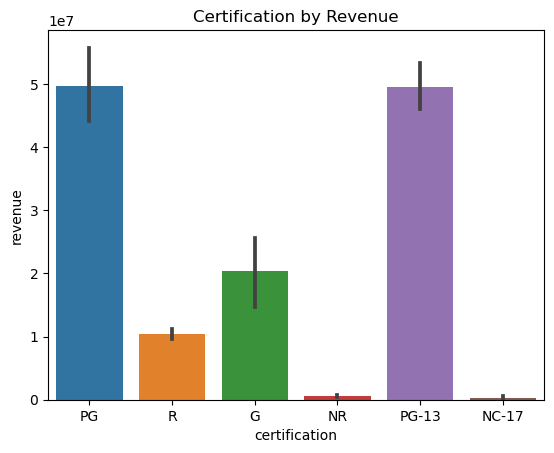

In [47]:
fig, ax = plt.subplots()

ax = sns.barplot(data=groups_df, x=groups_df['certification'], y=groups_df['revenue'])
ax.set_title('Certification by Revenue');

## Comparison tests 

In [48]:
values = groups_df['revenue']
labels = groups_df['certification']

In [49]:
tukey_q1 = pairwise_tukeyhsd(values, labels)
tukey_q1.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NC-17,-20056101.6834,0.0121,-37335290.1278,-2776913.239,True
G,NR,-19826813.2452,0.0,-29203656.0434,-10449970.4469,True
G,PG,29289498.1588,0.0,19189949.8491,39389046.4684,True
G,PG-13,29176685.3463,0.0,19776997.2279,38576373.4646,True
G,R,-10003764.8642,0.0222,-19134194.5763,-873335.1521,True
NC-17,NR,229288.4382,1.0,-14963354.2805,15421931.1568,False
NC-17,PG,49345599.8421,0.0,33696571.5026,64994628.1817,True
NC-17,PG-13,49232787.0296,0.0,34026033.6406,64439540.4187,True
NC-17,R,10052336.8192,0.3992,-4989470.2079,25094143.8463,False
NR,PG,49116311.404,0.0,43264224.9779,54968397.8301,True


- shows 12 significant results
- reject null hypthesis for the following groups: 

     - G and NC-17
     - G and NR
     - G and PG
     - G and PG-13
     - G and R
     - NC-17 and PG
     - NC-17 and PG-13
     - NR and PG
     - NR and PG-13
     - NR and R
     - PG and R
     - PG-13 and R

# Q 2: Do movies that are over 2.5 hours long earn more revenue than movies that are 1.5 hours long (or less)?

## State Null and Alternative Hypothesis

- Null hypothesis: Movies that are over 2.5 hours long do not earn more revenue than movies that are 1.5 hours long (or less).
- Alternative hypothesis: Movies that are over 2.5 hours long earn significantly more revenue than movies that are 1.5 hours long (or less).
- Alpha: 0.05

## Determine the correct test to perform

- numeric data (revenue)
- compare 2 samples/groups
- We therefore want to perform a independent-test


**According to the work flow, ANOVA test has the following assumptions:**
- No significant outliers
- Equal variance
- Normality

## Separate Groups

In [50]:
long_movie = df_combined[df_combined['runtime'] >= 150]
long_movie

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
tt0139500,0.0,/a56yntKq9u00uzin9EuNyQ1ym5A.jpg,"{'id': 699053, 'name': 'The Fontainhas Collect...",0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,87063.0,pt,No Quarto da Vanda,"An unflinching, fragmentary look at a handful ...",...,0.0,171.0,"[{'english_name': 'Portuguese', 'iso_639_1': '...",Released,NaN,In Vanda's Room,0.0,6.600,39.0,NaN
tt0151150,0.0,/moKRFO2pjDfMjEYDiS2QBqItWEL.jpg,NaN,6900000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,131940.0,hi,जोश,Two gangs fight for control of the streets: th...,...,15000000.0,157.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Full of life,Josh,0.0,5.900,54.0,NaN
tt0172495,0.0,/swpjSgGmBCx6QgfO4rgv5vBzqHL.jpg,"{'id': 1069584, 'name': 'Gladiator Collection'...",103000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,98.0,en,Gladiator,"In the year 180, the death of emperor Marcus A...",...,465361176.0,155.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A hero will rise.,Gladiator,0.0,8.207,16670.0,NaN
tt0187393,0.0,/c9xSFZQtC4c16Vn5CMOaB1pGk9J.jpg,NaN,110000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",NaN,2024.0,en,The Patriot,After proving himself on the field of battle i...,...,215294342.0,165.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some things are worth fighting for.,The Patriot,0.0,7.161,3476.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9680090,0.0,/ddtv2gFUFbZq6d0JnEdaHSbC1dh.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 10749, '...",NaN,646330.0,te,తిప్పరా మీసం,An extremely talented DJ who works at a local ...,...,0.0,151.0,"[{'english_name': 'Telugu', 'iso_639_1': 'te',...",Released,NaN,Thipparaa Meesam,0.0,6.000,1.0,NaN
tt9698626,0.0,NaN,NaN,0.0,[],NaN,621445.0,en,WhatsApp Love,Aditya is top class executive of a company as ...,...,0.0,150.0,[],Released,NaN,WhatsApp Love,0.0,0.000,0.0,NaN
tt9789670,0.0,/dyVTrO9hMZR1IkqsobUQfJ6jShX.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,620271.0,ml,പൊറിഞ്ചു മറിയം ജോസ്,Kattalan Porinju and Jose are friends as thick...,...,0.0,150.0,"[{'english_name': 'Malayalam', 'iso_639_1': 'm...",Released,NaN,Porinju Mariam Jose,0.0,6.800,24.0,NaN


In [51]:
short_movie = df_combined[df_combined['runtime'] <= 90]
short_movie

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
tt0119273,0.0,/f5C03doOWiauu37bToKXtpgP5bS.jpg,"{'id': 141086, 'name': 'Heavy Metal Collection...",15000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,16225.0,en,Heavy Metal 2000,Upon discovery of a shard of what could be the...,...,0.0,88.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,not to survive the fight in the external world...,Heavy Metal 2000,0.0,6.072,187.0,R
tt0119495,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,51181.0,en,Love 101,A group of raucous college buds living the Dor...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Love 101,0.0,0.000,0.0,R
tt0120467,0.0,/knok3mNReKqPTplnnqz7E4dd7mD.jpg,NaN,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",NaN,19085.0,en,Vulgar,Vulgar is about a man who is a children's clow...,...,14904.0,87.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Everyone loves a clown... some more than others.,Vulgar,0.0,5.500,44.0,R
tt0120630,0.0,/xWG7emUlBPhsJ2MyQHqH0poeXwm.jpg,"{'id': 718551, 'name': 'Chicken Run Collection...",45000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,7443.0,en,Chicken Run,The creators of Wallace & Gromit bring you an ...,...,224834564.0,84.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,This ain't no chick flick. It's poultry in mot...,Chicken Run,0.0,6.748,4409.0,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9900552,0.0,/hS5mI8h0Hq6LRSnycjPxVMPGIjj.jpg,"{'id': 991942, 'name': 'The Sacred Riana - Col...",0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,584561.0,id,The Sacred Riana: Beginning,"In her childhood, Riana lived in a small town ...",...,0.0,0.0,"[{'english_name': 'Indonesian', 'iso_639_1': '...",Released,NaN,The Sacred Riana: Beginning,0.0,4.500,2.0,NaN
tt9904250,0.0,/aZ1Gb4TDDzGzKbF9tG66fKrrKQw.jpg,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://dafilmfestival.com/es/pelicula/la-rein...,649072.0,es,La reina de los lagartos,"A spaceship is about to come to pick up Javi, ...",...,0.0,63.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,The Queen of the Lizards,0.0,5.600,17.0,NaN
tt9904820,0.0,NaN,NaN,0.0,[],NaN,599501.0,en,American Terror Story,The ghost of a young asian girl who committed ...,...,0.0,88.0,[],Released,NaN,American Terror Story,0.0,1.000,1.0,NaN


In [52]:
long_revenue = long_movie['revenue']
short_revenue = short_movie['revenue']

## Testing Assumptions

## Checking Assumptions of No. Sig. Outliers

In [53]:
# long revenue
zscores_long = stats.zscore(long_revenue)
outliers_long = abs(zscores_long)>3
print(f'Len: {len(long_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_long)}')

long_revenue = long_revenue[~outliers_long]
print(f'Len: {len(long_revenue)}')

Len: 1097
Number of Ouliers: 23
Len: 1074


In [54]:
# short revenue
zscores_short = stats.zscore(short_revenue)
outliers_short = abs(zscores_short)>3
print(f'Len: {len(short_revenue)}')
print(f'Number of Ouliers: {np.sum(outliers_short)}')

short_revenue = short_revenue[~outliers_short]
print(f'Len: {len(short_revenue)}')

Len: 23874
Number of Ouliers: 183
Len: 23691


## Test for Normality

- Each group needs to have n >= 15.
- Each group is greater than 15, we can safely igonore the assumption of normality

## Test for Equal Variance

In [55]:
stats.levene(long_revenue, short_revenue)

LeveneResult(statistic=1306.5227898570863, pvalue=7.550891097426177e-279)

- We met the assumption of normality but did NOT meet the assumption of equal variance.
- We will therefore run a Welch's t-test instead by adding equal_var=False to stats.ttest_ind

## Final Hypothesis Test - Welch's T-Test

In [57]:
result = stats.ttest_ind(long_revenue, short_revenue, equal_var=False)
print(result)
result.pvalue  < .05

Ttest_indResult(statistic=7.915964702639874, pvalue=6.0871665130585586e-15)


True

## Visualization

In [58]:
long_revenue_df = pd.DataFrame(long_revenue)
long_revenue_df['runtime'] = 'long'
long_revenue_df

,revenue,runtime
imdb_id,,
tt0116391,0.0,long
tt0139500,0.0,long
tt0151150,15000000.0,long
tt0172495,465361176.0,long
tt0187393,215294342.0,long
...,...,...
tt9680090,0.0,long
tt9698626,0.0,long
tt9789670,0.0,long


In [59]:
short_revenue_df = pd.DataFrame(short_revenue)
short_revenue_df['runtime'] = 'short'
short_revenue_df

,revenue,runtime
imdb_id,,
tt0113026,0.0,short
tt0119273,0.0,short
tt0119495,0.0,short
tt0120467,14904.0,short
tt0120733,0.0,short
...,...,...
tt9900552,0.0,short
tt9904250,0.0,short
tt9904820,0.0,short


In [60]:
plot_q2 = pd.concat([long_revenue_df, short_revenue_df])
plot_q2

,revenue,runtime
imdb_id,,
tt0116391,0.0,long
tt0139500,0.0,long
tt0151150,15000000.0,long
tt0172495,465361176.0,long
tt0187393,215294342.0,long
...,...,...
tt9900552,0.0,short
tt9904250,0.0,short
tt9904820,0.0,short


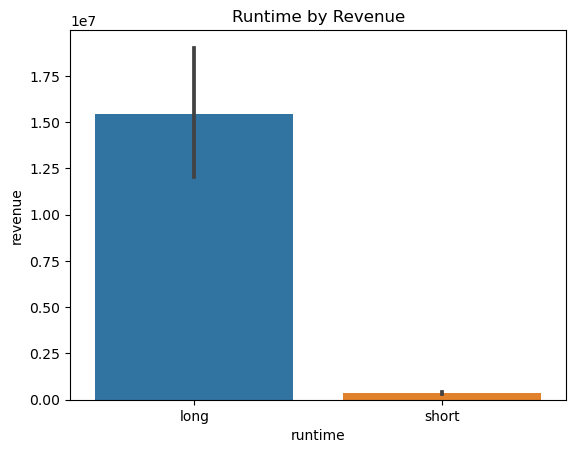

In [61]:
fig, ax = plt.subplots()

ax = sns.barplot(data=plot_q2, x='runtime', y='revenue')
ax.set_title('Runtime by Revenue');

- P-value <0.05, reject null hypothesis and support alternative hypothesis

# **Q 3: Do some movie genres earn more revenue than others?**

## State Null and Alternative Hypothesis

- Null hypothesis: There is no difference in revenue between movie genres.
- Alternative hypothesis: There is a significant difference in revenue between movie genres.
- Alpha: 0.05

## Determine the correct test to perform

- Numeric data
- More than two groups/samples
- We want to run an ANOVA test

In [63]:
df_q3 = df_combined.copy()

In [64]:
print(type(df_q3['genres'][0]))
print(df_q3['genres'][0])

<class 'str'>
[{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}]


In [65]:
# function to replace single quotes to double quotes, for use with json
# apply json.loads to convert object type to list type
# iterate through list to extract 'name' from dict
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [66]:
df_q3['genres_list'] = df_q3['genres'].apply(get_genre_name)
df_q3_explode = df_q3.explode('genres_list')
df_q3_explode.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,genres_list
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN,Comedy
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN,Music
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN,Romance
tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.1,8.0,NaN,Science Fiction
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.0,1.0,NaN,Drama


In [67]:
cols_to_make = df_q3_explode['genres_list'].dropna().unique()
cols_to_make

array(['Comedy', 'Music', 'Romance', 'Science Fiction', 'Drama', 'Action',
       'Crime', 'Adventure', 'Animation', 'Fantasy', 'Horror', 'Thriller',
       'History', 'Family', 'Mystery', 'Western', 'War', 'TV Movie',
       'Documentary'], dtype=object)

In [68]:
pd.set_option('display.max_columns', None)

In [69]:
for col in cols_to_make:
    df_q3[col] = df_q3['genres'].str.contains(col)
df_q3.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,genres_list,Comedy,Music,Romance,Science Fiction,Drama,Action,Crime,Adventure,Animation,Fantasy,Horror,Thriller,History,Family,Mystery,Western,War,TV Movie,Documentary
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,2.787,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN,"[Comedy, Music, Romance]",True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,0.622,/h9bWO13nWRGZJo4XVPiElXyrRMU.jpg,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-11-15,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN,[Science Fiction],False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",1.463,/yB5wRu4uyXXwZA3PEj8cITu0xt3.jpg,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2000-04-14,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN,"[Drama, Action, Crime]",False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False
tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,843.0,cn,花樣年華,Two neighbors become intimate after discoverin...,32.450,/iYypPT4bhqXfq1b6EnmxvRt6b2Y.jpg,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2000-09-29,14204632.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.111,2257.0,PG,"[Drama, Romance]",False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
tt0118852,0.0,/vceiGZ3uavAEHlTA7v0GjQsGVKe.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,"When Harry Levine, an aging, unsuccessful Gree...",2.970,/nZGWnSuf1FIuzyEuMRZHHZWViAp.jpg,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-02,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.804,51.0,R,[Drama],False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [70]:
# remove original 'genres' column
df_q3.drop(columns='genres', inplace=True)
df_q3.head(1)

,adult,backdrop_path,belongs_to_collection,budget,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification,genres_list,Comedy,Music,Romance,Science Fiction,Drama,Action,Crime,Adventure,Animation,Fantasy,Horror,Thriller,History,Family,Mystery,Western,War,TV Movie,Documentary
imdb_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,2.787,/hfO64mXz3DgUxkBVU7no2UWRP7x.jpg,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...","[{'iso_3166_1': 'US', 'name': 'United States o...",2000-09-22,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.5,22.0,NaN,"[Comedy, Music, Romance]",True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Separate Groups

In [71]:
groups_q3 = {}
## Loop through all unique categories
for i in df_q3.columns[26:]:
    ## Get series for group and rename
    data = df_q3.loc[df_q3[i],'revenue'].copy()
    
    # save into the dictionary
    groups_q3[i] = data
groups_q3.keys()

dict_keys(['Music', 'Romance', 'Science Fiction', 'Drama', 'Action', 'Crime', 'Adventure', 'Animation', 'Fantasy', 'Horror', 'Thriller', 'History', 'Family', 'Mystery', 'Western', 'War', 'TV Movie', 'Documentary'])

## Testing Assumptions

- No significant outliers
- Normality
- Equal variance

## Checking Assumptions of No Significant Outliers

In [72]:
for i in groups_q3:
    print(f'{i} - Number of rows: {len(groups_q3[i])}')
    z_score = stats.zscore(groups_q3[i])
    outliers = abs(z_score)>3
    print(f'{i} - Number of outliers: {np.sum(outliers)}')
    
    groups_q3[i] = groups_q3[i][~outliers]
    print(f'{i} - Number of rows: {len(groups_q3[i])}')
    print('')

Music - Number of rows: 1117
Music - Number of outliers: 16
Music - Number of rows: 1101

Romance - Number of rows: 7436
Romance - Number of outliers: 122
Romance - Number of rows: 7314

Science Fiction - Number of rows: 2915
Science Fiction - Number of outliers: 59
Science Fiction - Number of rows: 2856

Drama - Number of rows: 26350
Drama - Number of outliers: 312
Drama - Number of rows: 26038

Action - Number of rows: 6581
Action - Number of outliers: 131
Action - Number of rows: 6450

Crime - Number of rows: 4269
Crime - Number of outliers: 62
Crime - Number of rows: 4207

Adventure - Number of rows: 3011
Adventure - Number of outliers: 92
Adventure - Number of rows: 2919

Animation - Number of rows: 1841
Animation - Number of outliers: 55
Animation - Number of rows: 1786

Fantasy - Number of rows: 2480
Fantasy - Number of outliers: 68
Fantasy - Number of rows: 2412

Horror - Number of rows: 8042
Horror - Number of outliers: 132
Horror - Number of rows: 7910

Thriller - Number of r

## Test for Normality

- each group is greater than 20, we can safely igonore the assumption of normality

## Test for Equal Variance

In [74]:
stats.levene(*groups_q3.values())

LeveneResult(statistic=279.3906842839984, pvalue=0.0)

- Does not meet assumption of equal variance.

## Final Hypothesis Test & Interpret Result

In [76]:
# Kruskal-Wallis Test
result_q3 = stats.kruskal( *groups_q3.values())
result_q3

KruskalResult(statistic=2485.0862040860134, pvalue=0.0)

In [77]:
## is our result significant
print(f"p-value={result_q3.pvalue:.10f}")
print(f"Significant: {result_q3.pvalue <.05}")

p-value=0.0000000000
Significant: True


- p-value is < 0.05; There is a significant difference in revenue between movie genres. 

In [79]:
groups_q3_df = pd.DataFrame(index=[0], data={'revenue': 0, 'genres':0})
groups_q3_df

,revenue,genres
0,0,0


In [80]:
for i in groups_q3:
    groups_q3_temp = pd.DataFrame(groups_q3[i])
    groups_q3_temp['genres'] = i
    groups_q3_df = pd.concat([groups_q3_df, groups_q3_temp])

groups_q3_df.index.name='imdb_id'
groups_q3_df

,revenue,genres
imdb_id,,
0,0.0,0
tt0113026,0.0,Music
tt0134630,0.0,Music
tt0146882,47126295.0,Music
tt0163080,0.0,Music
...,...,...
tt9581518,0.0,Documentary
tt9691482,0.0,Documentary
tt9741908,0.0,Documentary


In [81]:
groups_q3_df.drop(index=0, inplace=True)
groups_q3_df

,revenue,genres
imdb_id,,
tt0113026,0.0,Music
tt0134630,0.0,Music
tt0146882,47126295.0,Music
tt0163080,0.0,Music
tt0181875,47386287.0,Music
...,...,...
tt9581518,0.0,Documentary
tt9691482,0.0,Documentary
tt9741908,0.0,Documentary


In [82]:
df_agg = groups_q3_df.groupby('genres')['revenue'].mean().sort_values(ascending=False)
df_agg

genres
Adventure          4.231646e+07
Fantasy            2.171585e+07
Animation          1.930585e+07
Family             1.740391e+07
Science Fiction    1.623310e+07
Action             1.618052e+07
War                8.824364e+06
History            8.089012e+06
Crime              6.671663e+06
Thriller           5.002386e+06
Mystery            4.894135e+06
Western            4.697956e+06
Music              4.379533e+06
Romance            3.811444e+06
Drama              2.140975e+06
Horror             1.135349e+06
Documentary        5.287380e+03
TV Movie           1.291237e+03
Name: revenue, dtype: float64

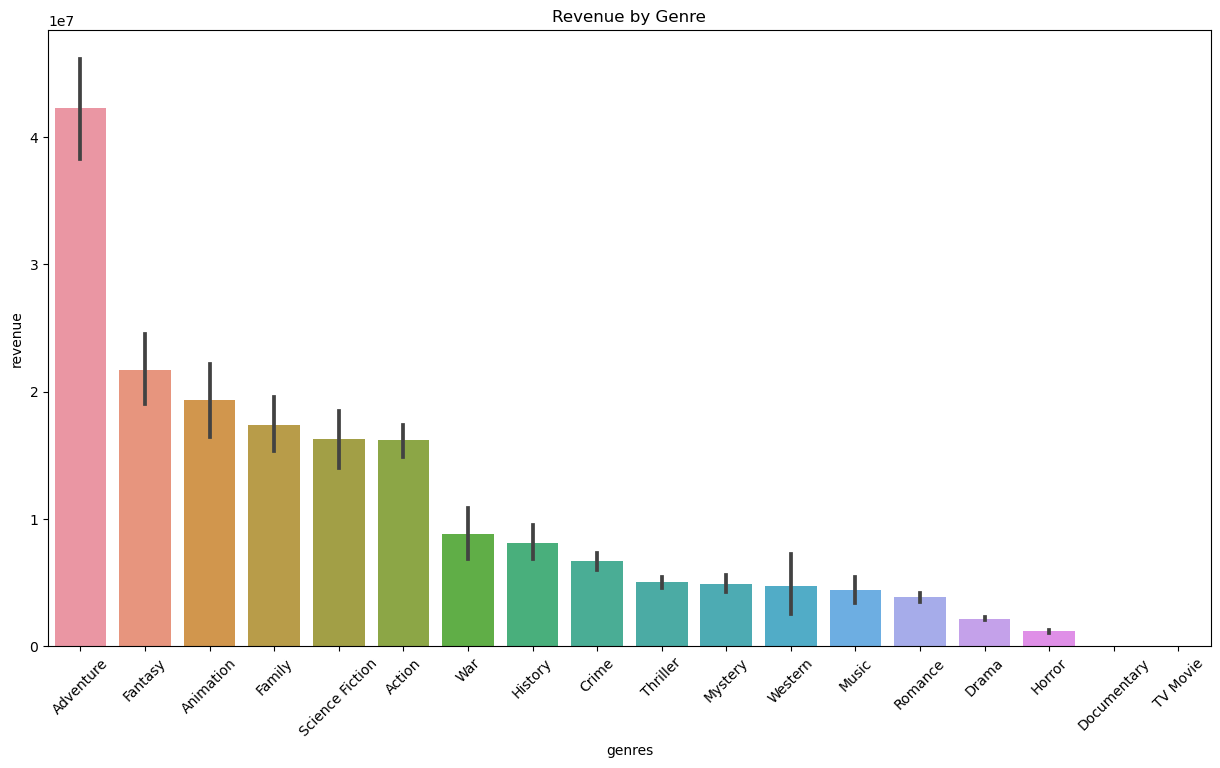

In [83]:
fig, ax = plt.subplots(figsize=(15, 8))

ax = sns.barplot(data=groups_q3_df, x='genres', y='revenue',
                order=df_agg.index)
ax.set_title('Revenue by Genre')

plt.xticks(rotation=45);

- According to the above visual, it appears that Adventure genre has the most significant difference. 

# Comparison Test

In [84]:
values_q3 = groups_q3_df['revenue']
labels_q3 = groups_q3_df['genres']

In [85]:
tukey_q3 = pairwise_tukeyhsd(values_q3, labels_q3)
tukey_q3.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Action,Adventure,26135938.5981,0.0,23243696.7252,29028180.471,True
Action,Animation,3125328.314,0.1381,-341421.3259,6592077.9539,False
Action,Crime,-9508861.9825,0.0,-12078288.8691,-6939435.0958,True
Action,Documentary,-16175237.3127,0.0,-23097404.8668,-9253069.7586,True
Action,Drama,-14039550.0407,0.0,-15842828.1652,-12236271.9161,True
Action,Family,1223383.686,0.9928,-1685806.0404,4132573.4125,False
Action,Fantasy,5535322.3944,0.0,2440881.0247,8629763.764,True
Action,History,-8091513.0929,0.0,-12062651.692,-4120374.4937,True
Action,Horror,-15045176.038,0.0,-17220350.0989,-12870001.9771,True
Action,Music,-11800991.6727,0.0,-16028783.677,-7573199.6685,True


In [86]:
tukey_df = pd.DataFrame(tukey_q3.summary().data)
tukey_df

,0,1,2,3,4,5,6
0,group1,group2,meandiff,p-adj,lower,upper,reject
1,Action,Adventure,26135938.5981,0.0,23243696.7252,29028180.471,True
2,Action,Animation,3125328.314,0.1381,-341421.3259,6592077.9539,False
3,Action,Crime,-9508861.9825,0.0,-12078288.8691,-6939435.0958,True
4,Action,Documentary,-16175237.3127,0.0,-23097404.8668,-9253069.7586,True
...,...,...,...,...,...,...,...
149,TV Movie,War,8823072.6046,0.0994,-608941.5587,18255086.768,False
150,TV Movie,Western,4696664.4675,0.9902,-6168702.5019,15562031.4369,False
151,Thriller,War,3821977.8396,0.245,-755422.6819,8399378.3611,False
152,Thriller,Western,-304430.2975,1.0,-7378743.2491,6769882.654,False


In [87]:
tukey_df.columns = tukey_df.iloc[0]
tukey_df.columns

Index(['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], dtype='object', name=0)

In [88]:
tukey_df.drop(index=0, inplace=True)
tukey_df

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Action,Adventure,26135938.5981,0.0,23243696.7252,29028180.471,True
2,Action,Animation,3125328.314,0.1381,-341421.3259,6592077.9539,False
3,Action,Crime,-9508861.9825,0.0,-12078288.8691,-6939435.0958,True
4,Action,Documentary,-16175237.3127,0.0,-23097404.8668,-9253069.7586,True
5,Action,Drama,-14039550.0407,0.0,-15842828.1652,-12236271.9161,True
...,...,...,...,...,...,...,...
149,TV Movie,War,8823072.6046,0.0994,-608941.5587,18255086.768,False
150,TV Movie,Western,4696664.4675,0.9902,-6168702.5019,15562031.4369,False
151,Thriller,War,3821977.8396,0.245,-755422.6819,8399378.3611,False
152,Thriller,Western,-304430.2975,1.0,-7378743.2491,6769882.654,False


In [89]:
tukey_df_true = tukey_df[tukey_df['reject'] == True]
tukey_df_true

,group1,group2,meandiff,p-adj,lower,upper,reject
1,Action,Adventure,26135938.5981,0.0,23243696.7252,29028180.471,True
3,Action,Crime,-9508861.9825,0.0,-12078288.8691,-6939435.0958,True
4,Action,Documentary,-16175237.3127,0.0,-23097404.8668,-9253069.7586,True
5,Action,Drama,-14039550.0407,0.0,-15842828.1652,-12236271.9161,True
7,Action,Fantasy,5535322.3944,0.0,2440881.0247,8629763.764,True
...,...,...,...,...,...,...,...
142,Romance,War,5012919.6471,0.019,375046.928,9650792.3663,True
144,Science Fiction,TV Movie,-16231804.8083,0.0,-24928772.8575,-7534836.7591,True
145,Science Fiction,Thriller,-11230710.0433,0.0,-13992404.7413,-8469015.3453,True
146,Science Fiction,War,-7408732.2037,0.0,-12418463.0232,-2399001.3841,True
